In [1]:
import numpy as np

from help_functies import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x_list = []
y_list = []
for i in range(1, 901):
    x_list.append(np.cos(0.1 * i * np.pi / 180))
    y_list.append(np.sin(0.1 * i * np.pi / 180))

In [3]:
ts = np.linspace(0, 1800, 1801)
l = len(ts)
data_np = np.hstack([np.reshape(ts, (l,1)), np.zeros((l, 6))])
data = pd.DataFrame(data_np, columns=['timestamp', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro'])
data['z_gyro'][901:] = np.array([100]*900)
data['x_acc'][:901] = np.ones(901)
data['x_acc'][901:] = x_list
data['y_acc'][901:] = y_list

data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
1,1.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
2,2.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
3,3.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
4,4.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1796,1796.0,6.981260e-03,0.999976,0.0,0.0,0.0,100.0
1797,1797.0,5.235964e-03,0.999986,0.0,0.0,0.0,100.0
1798,1798.0,3.490651e-03,0.999994,0.0,0.0,0.0,100.0
1799,1799.0,1.745328e-03,0.999998,0.0,0.0,0.0,100.0


In [4]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
print(max_eigenvector)

[0.         0.70710678 0.         0.70710678]


In [5]:
print(rotate_vector([1,0,0], max_eigenvector))

[0. 0. 1.]


In [6]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [7]:
q = q11
q_list = [q]

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    q = quat_mul(q, expq_omega)

    q_list.append(q)

In [19]:
rot_vec_list = []
for q in q_list:
    rot_vec_list.append(logq(q))
rot_vecs = np.concatenate(rot_vec_list)
rot_vecs = np.reshape(rot_vecs, (int(len(rot_vecs) / 3), 3))
print(rot_vecs * 180 / np.pi)
print(np.linalg.norm(rot_vecs[-1,:] * 180 / np.pi))

[[ 63.63961031   0.          63.63961031]
 [ 63.63961031   0.          63.63961031]
 [ 63.63961031   0.          63.63961031]
 ...
 [ 69.32911358 -69.08753071  69.32911358]
 [ 69.30562259 -69.1847669   69.30562259]
 [ 69.2820323  -69.2820323   69.2820323 ]]
119.99999999999979


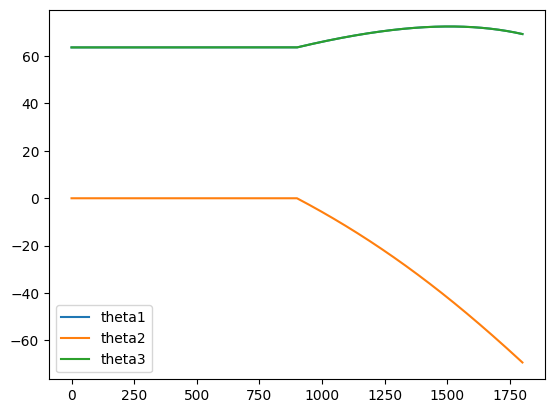

In [17]:
plt.plot(rot_vecs[:,0] * 180 / np.pi, label='theta1')
plt.plot(rot_vecs[:,1] * 180 / np.pi, label='theta2')
plt.plot(rot_vecs[:,2] * 180 / np.pi, label='theta3')
plt.legend()
plt.show()

C:\Users\jelte\Documents\dobbelsteenbep\Project files\help_functies.py:46: RuntimeWarning: invalid value encountered in scalar divide
  psi = np.arctan((2*x*y-2*w*z)/((2*w**2)+(2*x**2)-1))
C:\Users\jelte\Documents\dobbelsteenbep\Project files\help_functies.py:48: RuntimeWarning: invalid value encountered in scalar divide
  phi = np.arctan((2*y*z-2*w*x)/((2*w**2)+(2*z**2)-1))
C:\Users\jelte\Documents\dobbelsteenbep\Project files\help_functies.py:47: RuntimeWarning: invalid value encountered in arcsin
  theta = -np.arcsin(2*x*z+2*w*y)


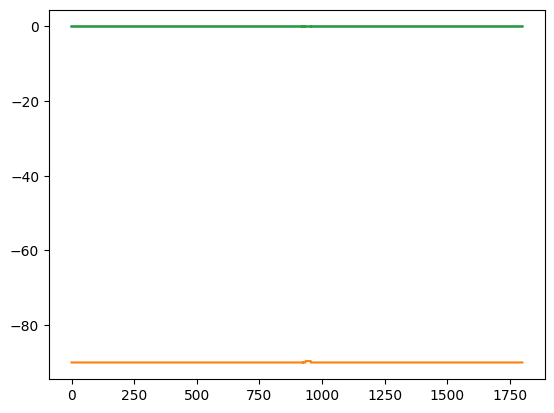

In [9]:
euler_x = []
euler_y = []
euler_z = []

q_norm = []
for q in q_list:
    if np.linalg.norm(q) > 1:
        q_norm.append(q / 1.00001)
    else:
        q_norm.append(q)

for q in q_norm:
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [10]:
for q in q_list:
    print(q)

[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         0.70710678]
[0.         0.70710678 0.         